# Local reliability: analyse

Evaluate local reliability for 3 uncertain parameters (fimp_14, psepbqarmax and triang). The intention is to try out the normalised severity function (relative to the solution severity); is the sample point more or less violated than the solution point?

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from infeas import analyse
import easyvvuq as uq

In [11]:
campaign_names = [
    "3p_infeas_sol_no_norm",  # 3 params, infeasable solution, no severity normalisation, unc params expanded to include solution
    "3p_infeas_sol_norm",  # Same, but but solution severity normalisation
]

# 1p: triang
# 2p: triang, psepbqarmax
# 3p: triang, psepbqarmax, fimp_14

# Campaign name bug: string pattern must match unique campaign
campaigns = {}
for campaign_name in campaign_names:
    campaigns[campaign_name] = analyse.get_campaign(campaign_name)

Reading in campaign database.
Reading in campaign database.


Peek at samples from one campaign: check out a responses.

In [12]:
qois = [
    "rms_vio_constr_res",
]
samples = analyse.get_samples(campaigns["3p_infeas_sol_no_norm"])
samples[qois].describe()

,rms_vio_constr_res
count,150.000000
mean,0.069566
std,0.005863
min,0.058832
25%,0.065395
50%,0.068698
75%,0.073704
max,0.083282


### Distribution of violated constraint residuals

In [13]:
response_series = []
for campaign_name in campaigns:
    # TODO How are these different?
    # samples = campaign.get_collation_result()
    # samples = campaign.analyse(qoi_cols=qois)

    results = campaigns[campaign_name].analyse(qoi_cols=qois)
    results.samples.columns = results.samples.columns.droplevel(1)
    samples = results.samples["rms_vio_constr_res"]
    # Response series for one campaign
    samples = samples.rename(campaign_name)
    response_series.append(samples)

# Concatenate list of response series into single df
campaigns_responses = pd.concat(response_series, axis=1)

## Preliminary result

3 uncertain params, no normalisation of severity function, unc params extended to include solution point.

Text(0, 0.5, 'CDF')

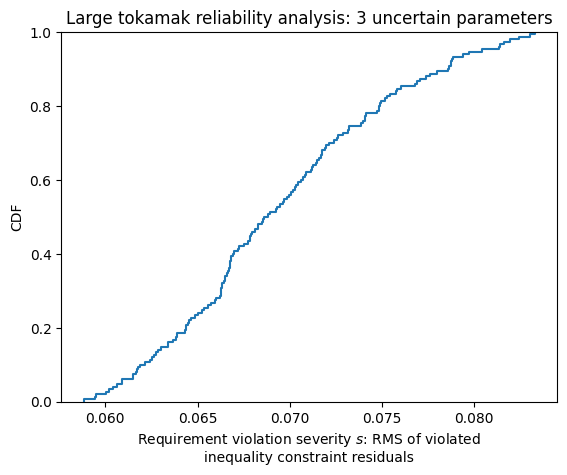

In [14]:
fig, ax = plt.subplots()
sns.ecdfplot(data=campaigns_responses["3p_infeas_sol_no_norm"], ax=ax)
ax.set_title("Large tokamak reliability analysis: 3 uncertain parameters")
ax.set_xlabel(
    "Requirement violation severity $s$: RMS of violated\ninequality constraint residuals"
)
ax.set_ylabel("CDF")
# ax.set_xlim(0.0)

As
$$R = F_s(0\mid\theta),$$
Reliability $R = 0$ for this solution point under uncertainty. There is no sample point where $s = 0$; no samples are feasible. This is probably due to the solution point itself not being feasible: $s = 0.0604$ for the solution.

## Normalised severity

Try normalising the severity by subtracting the severity of the solution.

Text(0.004, 0.13166666666666668, 'Reliability R = 0.11')

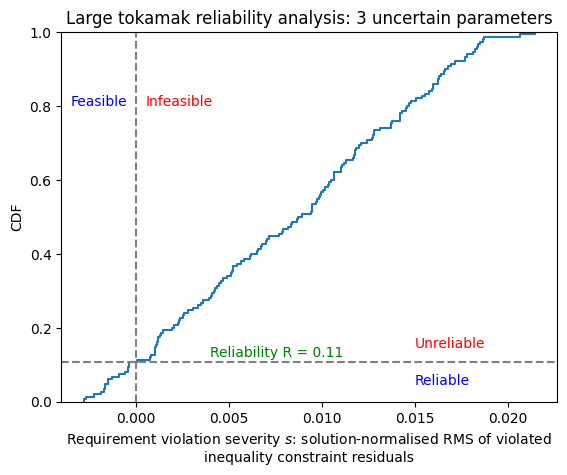

In [33]:
fig, ax = plt.subplots()
sns.ecdfplot(data=campaigns_responses["3p_infeas_sol_norm"], ax=ax)
ax.set_title("Large tokamak reliability analysis: 3 uncertain parameters")
ax.set_xlabel(
    "Requirement violation severity $s$: solution-normalised RMS of violated\ninequality constraint residuals"
)
ax.set_ylabel("CDF")

# Intersection lines
x, y = ax.lines[0].get_data()
thresh = 0.0
# Find index of sign-change around threshold
thresh_idx = np.nonzero(np.diff(np.sign(x - thresh)))[0]
y_val = y[thresh_idx[0]]
ax.axhline(y_val, color="grey", linestyle="dashed")
ax.axvline(0.0, color="grey", linestyle="dashed")

# Annotation positions
reliable_x = 0.015
reliable_y_pad = 0.05
# TODO rel to center?
ax.annotate("Infeasible", (0.0005, 0.8), color="red")
ax.annotate("Feasible", (-0.0035, 0.8), color="blue")
ax.annotate(
    "Unreliable",
    (reliable_x, y_val + reliable_y_pad),
    color="red",
    verticalalignment="center",
)
ax.annotate(
    "Reliable",
    (reliable_x, y_val - reliable_y_pad),
    color="blue",
    verticalalignment="center",
)
ax.annotate(
    f"Reliability R = {y_val:.2}",
    (0.004, y_val + reliable_y_pad / 2),
    color="green",
    verticalalignment="center",
)

This gives $R > 0$ for the solution point under uncertainty: 0.033 of the samples were more feasible than the solution point.

However, this normalisation of $s$ is unsatisfactory: it should be the case that $s_{soln} \leq 0$ (i.e. solver and severity metric agree that solution is feasible). This would remove the need for this normalisation.